In [37]:
PRFX = 'Prepbbox0903'

In [38]:
INPUT_SHAPE = (1400, 2100)
p_input = '../input'
p_output = f'../output/{PRFX}'
from pathlib import Path
Path(p_output).mkdir(exist_ok=True)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [40]:
df = pd.read_csv(f'{p_input}/train.csv')
df.shape

(22184, 2)

In [41]:
def rle_decode(mask_rle, shape=INPUT_SHAPE):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

(77, 1361) (1052, 1310)


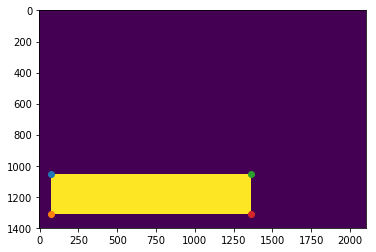

In [42]:
img = rle_decode(df.EncodedPixels[df.EncodedPixels.notnull()].sample().values[0])

[(y_min, y_max), (x_min, x_max)]= [(o.min(), o.max()) for o in np.where(img==1)]
print((x_min, x_max), (y_min, y_max))
plt.imshow(img);
plt.plot(x_min, y_min, 'o');
plt.plot(x_min, y_max, 'o');
plt.plot(x_max, y_min, 'o');
plt.plot(x_max, y_max, 'o');

In [43]:
def rle2box(mask_rle, shape=INPUT_SHAPE):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape, order='F')  # Needed to align to RLE direction 
    [(y_min, y_max), (x_min, x_max)]= [(o.min(), o.max()) for o in np.where(img==1)]
    return x_min, y_min, x_max, y_max

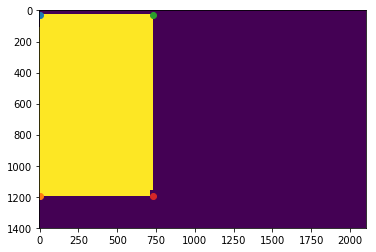

In [44]:
rle = df.EncodedPixels[df.EncodedPixels.notnull()].sample().values[0]
img = rle_decode(rle)
x_min, y_min, x_max, y_max = rle2box(rle)
plt.imshow(img);
plt.plot(x_min, y_min, 'o');
plt.plot(x_min, y_max, 'o');
plt.plot(x_max, y_min, 'o');
plt.plot(x_max, y_max, 'o');

In [45]:
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [46]:
# df = pd.read_csv(f'{p_input}/train.csv')
df['Image'] = df.Image_Label.apply(lambda x: x.split('_')[0])
df['Label'] = df.Image_Label.apply(lambda x: x.split('_')[1])
df = df[df.EncodedPixels.notnull()]

In [47]:
lbls = list(set(df.Label))
df_lbls = pd.DataFrame(list(zip(lbls, range(len(lbls)))))
df_lbls

,0,1
0,Fish,0
1,Sugar,1
2,Flower,2
3,Gravel,3


In [48]:
df_lbls.to_csv(f'{p_output}/lbls.csv', index=False, header=None)

In [49]:
df.shape

(11836, 4)

In [50]:
df.head()

,Image_Label,EncodedPixels,Image,Label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


In [51]:
bboxes = df.EncodedPixels.progress_apply(rle2box)

100%|██████████| 11836/11836 [04:29<00:00, 43.85it/s]


In [52]:
len(bboxes)

11836

In [53]:
df_xys = pd.DataFrame(list(bboxes))
df_xys.columns = ['x1', 'y1', 'x2', 'y2']

In [54]:
df_xys.head()

,x1,y1,x2,y2
0,189,317,1183,1253
1,968,313,2094,1365
2,167,9,2086,889
3,956,878,2097,1396
4,48,294,944,643


In [55]:
df.shape, df_xys.shape

((11836, 4), (11836, 4))

In [56]:
df_bb = pd.concat([df.reset_index(), df_xys.reset_index()], axis=1)
df_bb.head()

,index,Image_Label,EncodedPixels,Image,Label,index,x1,y1,x2,y2
0,0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,0,189,317,1183,1253
1,1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,1,968,313,2094,1365
2,4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,2,167,9,2086,889
3,5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,3,956,878,2097,1396
4,7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,4,48,294,944,643


In [57]:
df_bb.shape

(11836, 10)

In [58]:
df_bb.columns

Index(['index', 'Image_Label', 'EncodedPixels', 'Image', 'Label', 'index',
       'x1', 'y1', 'x2', 'y2'],
      dtype='object')

In [59]:
df_bb = df_bb[['Image', 'x1', 'y1', 'x2', 'y2', 'Label']]

In [60]:
df_bb.head()

,Image,x1,y1,x2,y2,Label
0,0011165.jpg,189,317,1183,1253,Fish
1,0011165.jpg,968,313,2094,1365,Flower
2,002be4f.jpg,167,9,2086,889,Fish
3,002be4f.jpg,956,878,2097,1396,Flower
4,002be4f.jpg,48,294,944,643,Sugar


In [61]:
df_bb.to_csv(f'{p_output}/boxes.csv', index=False, header=None)